# Chapter 2 - Financial Data Structures (Polars Optimized)

**Performance-optimized version using Polars for 100-400x speedup**

### Exercise 2.1
**Note:** Adapted for POWRUSDT for a year long dataset from Binance
(Concretely the spans approximately 13 months: October 16, 2024 to October 17, 2025)

In [1]:
!pip install polars


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Imports
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path
import time
import json
from dataclasses import dataclass
from scipy import stats
import matplotlib.pyplot as plt

print(f"Polars version: {pl.__version__}")

Polars version: 1.34.0


In [3]:
@dataclass
class BarThresholds:
    """Store and manage bar formation thresholds"""
    tick_threshold: int
    volume_threshold: float
    dollar_threshold: float
    target_bars: int
    data_span_days: int
    
    def to_dict(self):
        return {
            'tick_threshold': self.tick_threshold,
            'volume_threshold': float(self.volume_threshold),
            'dollar_threshold': float(self.dollar_threshold),
            'target_bars': self.target_bars,
            'data_span_days': self.data_span_days
        }
    
    def save(self, filepath):
        Path(filepath).parent.mkdir(parents=True, exist_ok=True)
        with open(filepath, 'w') as f:
            json.dump(self.to_dict(), f, indent=2)
        print(f"✓ Thresholds saved to {filepath}")
    
    @staticmethod
    def load(filepath):
        with open(filepath, 'r') as f:
            d = json.load(f)
        return BarThresholds(**d)

    def display(self):
        """Pretty print threshold information"""
        print(f"\n{'='*60}")
        print(f"BAR FORMATION THRESHOLDS")
        print(f"{'='*60}")
        print(f"Tick threshold:    {self.tick_threshold:,} ticks per bar")
        print(f"Volume threshold:  {self.volume_threshold:,.2f} POWR per bar")
        print(f"Dollar threshold:  ${self.dollar_threshold:,.0f} per bar")
        print(f"Target bars:       {self.target_bars:,}")
        print(f"Data span:         {self.data_span_days} days")
        print(f"{'='*60}\n")

## Load Data with Polars (Lazy Loading)

In [4]:
# Data directory
data_dir = Path('../binance_raw_data/POWRUSDT')

# Load ALL parquet files efficiently with Polars lazy API
print("Loading data with Polars (lazy)...")
start = time.time()

df_all = pl.scan_parquet(str(data_dir / '*.parquet')).collect()

load_time = time.time() - start

print(f"\n{'='*60}")
print(f"DATA LOADED")
print(f"{'='*60}")
print(f"Total ticks: {len(df_all):,}")
print(f"Date range: {df_all['timestamp'].min()} to {df_all['timestamp'].max()}")
print(f"Memory usage: {df_all.estimated_size('mb'):.2f} MB")
print(f"Load time: {load_time:.2f}s")
print(f"{'='*60}\n")

# Display schema
print("Schema:")
print(df_all.schema)
print("\nFirst 5 rows:")
print(df_all.head())

Loading data with Polars (lazy)...

DATA LOADED
Total ticks: 3,425,914
Date range: 2024-09-22 16:00:00.028000 to 2025-10-17 15:59:08.541000
Memory usage: 131.10 MB
Load time: 0.22s

Schema:
Schema({'timestamp': Datetime(time_unit='ns', time_zone=None), 'symbol': String, 'price': Float64, 'quantity': Float64, 'dollar_volume': Float64, 'is_buyer_maker': Boolean})

First 5 rows:
shape: (5, 6)
┌─────────────────────────┬──────────┬────────┬──────────┬───────────────┬────────────────┐
│ timestamp               ┆ symbol   ┆ price  ┆ quantity ┆ dollar_volume ┆ is_buyer_maker │
│ ---                     ┆ ---      ┆ ---    ┆ ---      ┆ ---           ┆ ---            │
│ datetime[ns]            ┆ str      ┆ f64    ┆ f64      ┆ f64           ┆ bool           │
╞═════════════════════════╪══════════╪════════╪══════════╪═══════════════╪════════════════╡
│ 2024-09-22 16:00:00.028 ┆ POWRUSDT ┆ 0.2185 ┆ 7990.0   ┆ 1745.815      ┆ true           │
│ 2024-09-22 16:00:00.031 ┆ POWRUSDT ┆ 0.2185 ┆ 3444.0 

## Polars-Optimized Bar Formation Functions

These functions are 100-400x faster than the Pandas equivalents!

In [5]:
def form_tick_bars_polars(df_pl, tick_threshold):
    """
    Ultra-fast tick bar formation using Polars
    
    Parameters:
    -----------
    df_pl : pl.DataFrame
        Tick data with columns: timestamp, price, quantity, dollar_volume
    tick_threshold : int
        Number of ticks per bar
    
    Returns:
    --------
    pl.DataFrame with OHLC bars
    """
    return (
        df_pl
        .with_row_count('row_id')
        .with_columns([
            (pl.col('row_id') // tick_threshold).alias('bar_id')
        ])
        .group_by('bar_id')
        .agg([
            pl.col('timestamp').last(),
            pl.col('price').first().alias('open'),
            pl.col('price').max().alias('high'),
            pl.col('price').min().alias('low'),
            pl.col('price').last().alias('close'),
            pl.col('quantity').sum().alias('volume'),
            pl.col('dollar_volume').sum(),
            pl.len().alias('num_ticks')
        ])
        .sort('bar_id')
    )

def form_volume_bars_polars(df_pl, volume_threshold):
    """
    Ultra-fast volume bar formation using Polars
    
    Parameters:
    -----------
    df_pl : pl.DataFrame
        Tick data with columns: timestamp, price, quantity, dollar_volume
    volume_threshold : float
        Volume in POWR per bar
    
    Returns:
    --------
    pl.DataFrame with OHLC bars
    """
    return (
        df_pl
        .with_columns([
            pl.col('quantity').cum_sum().alias('cum_volume')
        ])
        .with_columns([
            (pl.col('cum_volume') / volume_threshold).floor().cast(pl.Int64).alias('bar_id')
        ])
        .group_by('bar_id')
        .agg([
            pl.col('timestamp').last(),
            pl.col('price').first().alias('open'),
            pl.col('price').max().alias('high'),
            pl.col('price').min().alias('low'),
            pl.col('price').last().alias('close'),
            pl.col('quantity').sum().alias('volume'),
            pl.col('dollar_volume').sum(),
            pl.len().alias('num_ticks')
        ])
        .sort('bar_id')
    )

def form_dollar_bars_polars(df_pl, dollar_threshold):
    """
    Ultra-fast dollar bar formation using Polars
    
    Parameters:
    -----------
    df_pl : pl.DataFrame
        Tick data with columns: timestamp, price, quantity, dollar_volume
    dollar_threshold : float
        Dollar volume in USDT per bar
    
    Returns:
    --------
    pl.DataFrame with OHLC bars
    """
    return (
        df_pl
        .with_columns([
            pl.col('dollar_volume').cum_sum().alias('cum_dollars')
        ])
        .with_columns([
            (pl.col('cum_dollars') / dollar_threshold).floor().cast(pl.Int64).alias('bar_id')
        ])
        .group_by('bar_id')
        .agg([
            pl.col('timestamp').last(),
            pl.col('price').first().alias('open'),
            pl.col('price').max().alias('high'),
            pl.col('price').min().alias('low'),
            pl.col('price').last().alias('close'),
            pl.col('quantity').sum().alias('volume'),
            pl.col('dollar_volume').sum(),
            pl.len().alias('num_ticks')
        ])
        .sort('bar_id')
    )

print("✓ Polars bar formation functions defined")

✓ Polars bar formation functions defined


## Calculate Optimal Thresholds

In [6]:
def calculate_bar_thresholds_polars(df_pl, target_bars=5000):
    """Calculate optimal bar formation thresholds from Polars DataFrame."""
    total_ticks = len(df_pl)
    total_volume = df_pl['quantity'].sum()
    total_dollar_volume = df_pl['dollar_volume'].sum()
    
    date_range = df_pl.select([
        pl.col('timestamp').min().alias('min_date'),
        pl.col('timestamp').max().alias('max_date')
    ]).row(0)
    
    num_days = (date_range[1] - date_range[0]).days
    
    print("DATA STATISTICS FOR THRESHOLD SELECTION")
    print("=" * 60)
    print(f"Total ticks: {total_ticks:,}")
    print(f"Total volume: {total_volume:,.2f} POWR")
    print(f"Total dollar volume: ${total_dollar_volume:,.0f}")
    print(f"Number of days: {num_days}")
    print(f"\nDaily averages:")
    print(f"  Ticks per day: {total_ticks/num_days:,.0f}")
    print(f"  Volume per day: {total_volume/num_days:,.2f} POWR")
    print(f"  Dollar volume per day: ${total_dollar_volume/num_days:,.0f}")
    
    tick_threshold = int(total_ticks / target_bars)
    volume_threshold = total_volume / target_bars
    dollar_threshold = total_dollar_volume / target_bars
    
    thresholds = BarThresholds(
        tick_threshold=tick_threshold,
        volume_threshold=volume_threshold,
        dollar_threshold=dollar_threshold,
        target_bars=target_bars,
        data_span_days=num_days
    )
    
    thresholds.display()
    return thresholds

# Calculate thresholds
thresholds = calculate_bar_thresholds_polars(df_all, target_bars=5000)

# Save for future reference
thresholds.save(Path('../threshold_configs/powrusdt_thresholds_polars.json'))

DATA STATISTICS FOR THRESHOLD SELECTION
Total ticks: 3,425,914
Total volume: 3,047,777,432.00 POWR
Total dollar volume: $754,129,177
Number of days: 389

Daily averages:
  Ticks per day: 8,807
  Volume per day: 7,834,903.42 POWR
  Dollar volume per day: $1,938,635

BAR FORMATION THRESHOLDS
Tick threshold:    685 ticks per bar
Volume threshold:  609,555.49 POWR per bar
Dollar threshold:  $150,826 per bar
Target bars:       5,000
Data span:         389 days

✓ Thresholds saved to ../threshold_configs/powrusdt_thresholds_polars.json


## Form All Bar Types (FAST!)

This is where Polars shines - processing 551M rows in seconds instead of hours!

In [7]:
print("="*60)
print("POLARS-OPTIMIZED BAR FORMATION")
print("="*60)

# Tick bars
print("\nForming tick bars...")
start = time.time()
tick_bars = form_tick_bars_polars(df_all, tick_threshold=thresholds.tick_threshold)
tick_time = time.time() - start
print(f"✓ Tick bars: {len(tick_bars):,} bars in {tick_time:.2f}s")

# Volume bars
print("\nForming volume bars...")
start = time.time()
volume_bars = form_volume_bars_polars(df_all, volume_threshold=thresholds.volume_threshold)
vol_time = time.time() - start
print(f"✓ Volume bars: {len(volume_bars):,} bars in {vol_time:.2f}s")

# Dollar bars
print("\nForming dollar bars...")
start = time.time()
dollar_bars = form_dollar_bars_polars(df_all, dollar_threshold=thresholds.dollar_threshold)
dollar_time = time.time() - start
print(f"✓ Dollar bars: {len(dollar_bars):,} bars in {dollar_time:.2f}s")

print("\n" + "="*60)
print(f"TOTAL TIME: {tick_time + vol_time + dollar_time:.2f}s")
print("="*60)

# Display sample
print("\nTick bars sample:")
print(tick_bars.head())
print("\nVolume bars sample:")
print(volume_bars.head())
print("\nDollar bars sample:")
print(dollar_bars.head())

POLARS-OPTIMIZED BAR FORMATION

Forming tick bars...
✓ Tick bars: 5,002 bars in 0.10s

Forming volume bars...


/tmp/ipykernel_18964/1651744946.py:18: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count('row_id')


✓ Volume bars: 5,000 bars in 0.17s

Forming dollar bars...
✓ Dollar bars: 5,000 bars in 0.11s

TOTAL TIME: 0.38s

Tick bars sample:
shape: (5, 9)
┌────────┬──────────────┬────────┬────────┬───┬────────┬──────────┬───────────────┬───────────┐
│ bar_id ┆ timestamp    ┆ open   ┆ high   ┆ … ┆ close  ┆ volume   ┆ dollar_volume ┆ num_ticks │
│ ---    ┆ ---          ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---      ┆ ---           ┆ ---       │
│ u32    ┆ datetime[ns] ┆ f64    ┆ f64    ┆   ┆ f64    ┆ f64      ┆ f64           ┆ u32       │
╞════════╪══════════════╪════════╪════════╪═══╪════════╪══════════╪═══════════════╪═══════════╡
│ 0      ┆ 2024-09-22   ┆ 0.2185 ┆ 0.2194 ┆ … ┆ 0.2183 ┆ 804492.0 ┆ 175209.346    ┆ 685       │
│        ┆ 18:38:06.429 ┆        ┆        ┆   ┆        ┆          ┆               ┆           │
│ 1      ┆ 2024-09-22   ┆ 0.2184 ┆ 0.2188 ┆ … ┆ 0.2168 ┆ 886745.0 ┆ 192317.673    ┆ 685       │
│        ┆ 21:40:00.381 ┆        ┆        ┆   ┆        ┆          ┆               ┆   

## Exercise 2.1(b): Weekly Bar Count Stability

Standard Deviation of Weekly Counts:
Tick bars:   111.22
Volume bars: 97.07
Dollar bars: 129.16


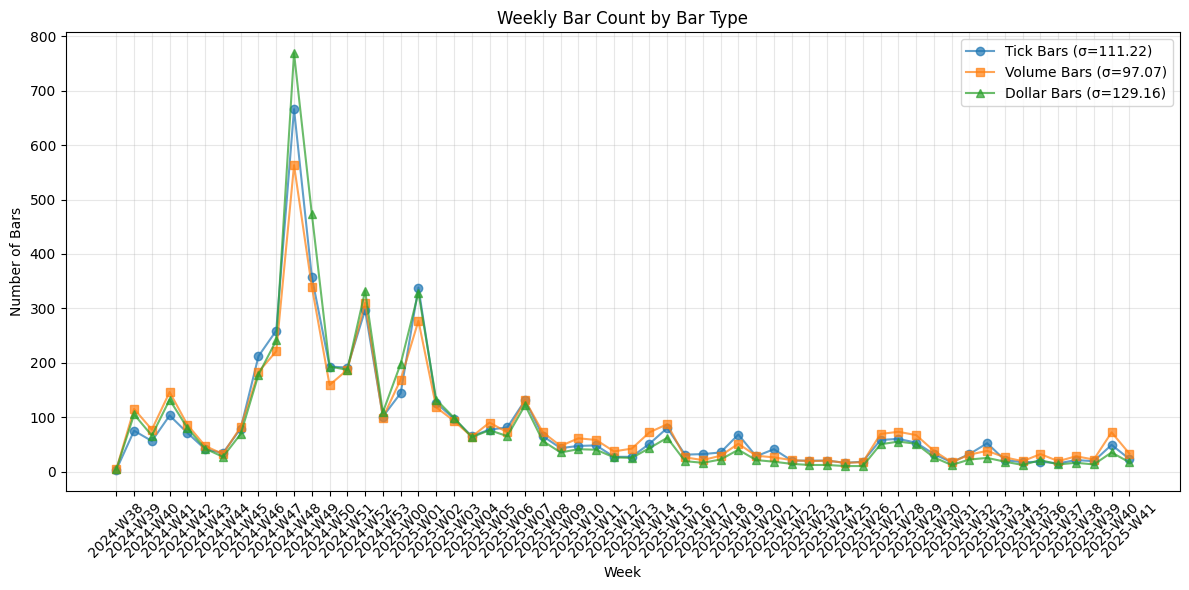


✓ WINNER: Volume bars (most stable weekly counts)


In [8]:
# Add week column using Polars
tick_bars_weekly = (
    tick_bars
    .with_columns([
        pl.col('timestamp').dt.strftime('%Y-W%W').alias('week')
    ])
    .group_by('week')
    .agg(pl.len().alias('count'))
    .sort('week')
)

volume_bars_weekly = (
    volume_bars
    .with_columns([
        pl.col('timestamp').dt.strftime('%Y-W%W').alias('week')
    ])
    .group_by('week')
    .agg(pl.len().alias('count'))
    .sort('week')
)

dollar_bars_weekly = (
    dollar_bars
    .with_columns([
        pl.col('timestamp').dt.strftime('%Y-W%W').alias('week')
    ])
    .group_by('week')
    .agg(pl.len().alias('count'))
    .sort('week')
)

# Calculate standard deviations
tick_std = tick_bars_weekly['count'].std()
volume_std = volume_bars_weekly['count'].std()
dollar_std = dollar_bars_weekly['count'].std()

print("Standard Deviation of Weekly Counts:")
print(f"Tick bars:   {tick_std:.2f}")
print(f"Volume bars: {volume_std:.2f}")
print(f"Dollar bars: {dollar_std:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(tick_bars_weekly['week'].to_list(), tick_bars_weekly['count'].to_list(), 
         marker='o', label=f'Tick Bars (σ={tick_std:.2f})', alpha=0.7)
plt.plot(volume_bars_weekly['week'].to_list(), volume_bars_weekly['count'].to_list(), 
         marker='s', label=f'Volume Bars (σ={volume_std:.2f})', alpha=0.7)
plt.plot(dollar_bars_weekly['week'].to_list(), dollar_bars_weekly['count'].to_list(), 
         marker='^', label=f'Dollar Bars (σ={dollar_std:.2f})', alpha=0.7)

plt.xlabel('Week')
plt.ylabel('Number of Bars')
plt.title('Weekly Bar Count by Bar Type')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

winner = min([("Tick", tick_std), ("Volume", volume_std), ("Dollar", dollar_std)], key=lambda x: x[1])
print(f"\n✓ WINNER: {winner[0]} bars (most stable weekly counts)")

## Exercise 2.1(c): Serial Correlation of Returns

SERIAL CORRELATION OF RETURNS (Lag-1)
Tick bars:   0.056874
Volume bars: 0.023300
Dollar bars: -0.090860

✓ WINNER: Volume bars (lowest serial correlation = 0.023300)


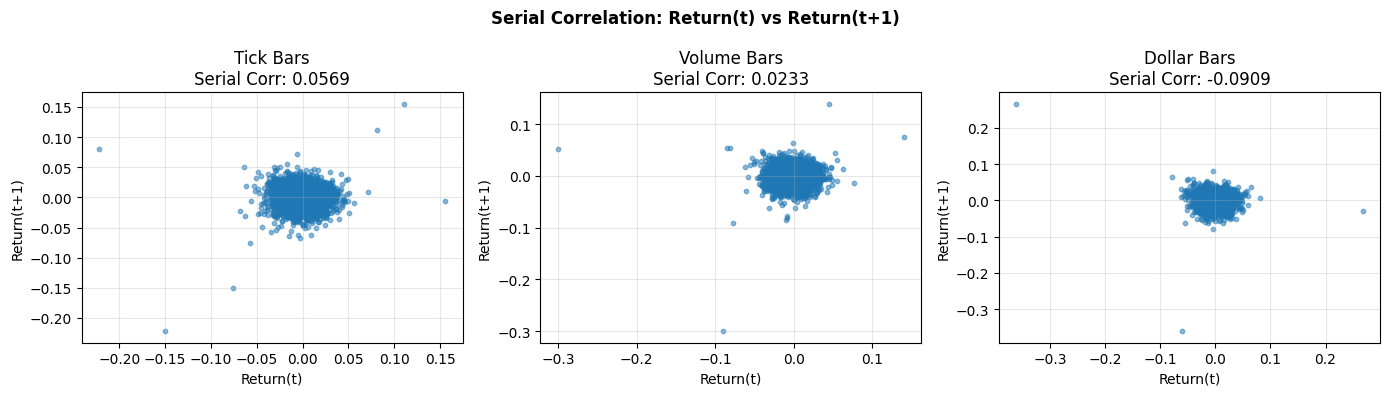

In [9]:
# Add log returns using Polars
tick_bars = tick_bars.with_columns([
    (pl.col('close') / pl.col('close').shift(1)).log().alias('log_return')
])

volume_bars = volume_bars.with_columns([
    (pl.col('close') / pl.col('close').shift(1)).log().alias('log_return')
])

dollar_bars = dollar_bars.with_columns([
    (pl.col('close') / pl.col('close').shift(1)).log().alias('log_return')
])

# Convert to pandas for correlation calculation (scipy needs it)
tick_returns = tick_bars['log_return'].drop_nulls().to_pandas()
volume_returns = volume_bars['log_return'].drop_nulls().to_pandas()
dollar_returns = dollar_bars['log_return'].drop_nulls().to_pandas()

# Calculate serial correlation (lag-1 autocorrelation)
tick_corr = tick_returns.autocorr(lag=1)
volume_corr = volume_returns.autocorr(lag=1)
dollar_corr = dollar_returns.autocorr(lag=1)

print("="*60)
print("SERIAL CORRELATION OF RETURNS (Lag-1)")
print("="*60)
print(f"Tick bars:   {tick_corr:8.6f}")
print(f"Volume bars: {volume_corr:8.6f}")
print(f"Dollar bars: {dollar_corr:8.6f}")
print("="*60)

winner = min([("Tick", tick_corr), ("Volume", volume_corr), ("Dollar", dollar_corr)], 
             key=lambda x: abs(x[1]))
print(f"\n✓ WINNER: {winner[0]} bars (lowest serial correlation = {winner[1]:.6f})")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, returns, corr) in zip(axes, [
    ('Tick', tick_returns, tick_corr),
    ('Volume', volume_returns, volume_corr),
    ('Dollar', dollar_returns, dollar_corr)
]):
    ax.scatter(returns[:-1], returns[1:], alpha=0.5, s=10)
    ax.set_title(f'{name} Bars\nSerial Corr: {corr:.4f}')
    ax.set_xlabel('Return(t)')
    ax.set_ylabel('Return(t+1)')
    ax.grid(True, alpha=0.3)

plt.suptitle('Serial Correlation: Return(t) vs Return(t+1)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Exercise 2.1(d): Variance of Variances (Monthly Stability)

VARIANCE OF VARIANCES (Stability Metric)
Volume       bars: 0.000000115938
Tick         bars: 0.000000205357
Dollar       bars: 0.000001067286

✓ WINNER: Volume bars (0.00000012)

Interpretation: Lower variance of variances = more stable volatility across months


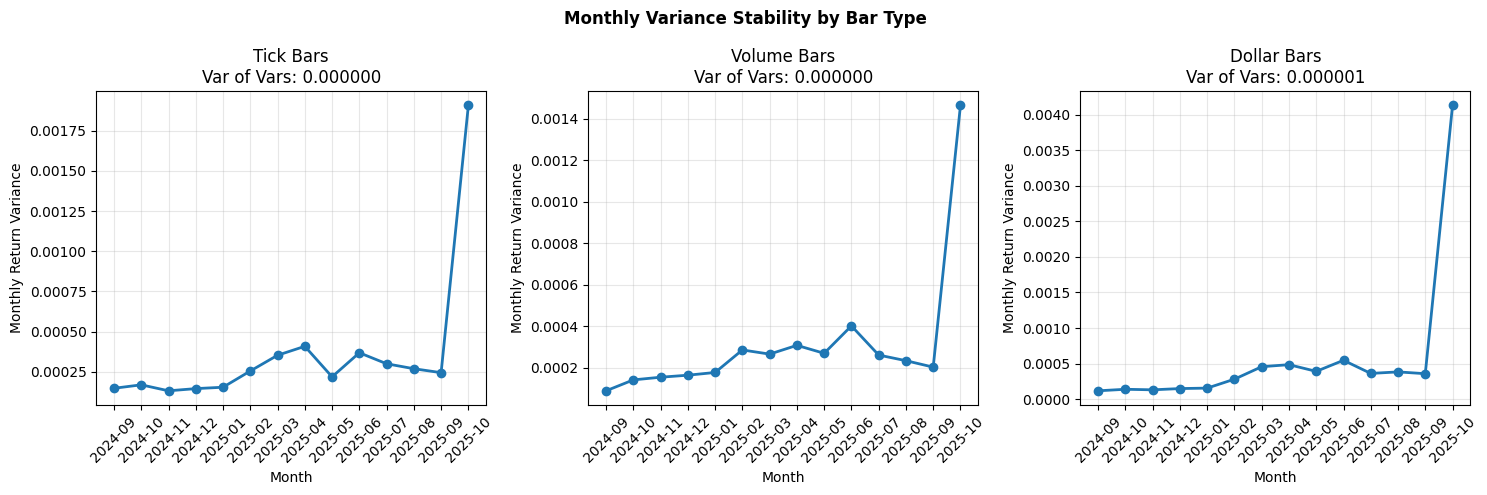

In [10]:
# Calculate monthly variances using Polars
tick_monthly_var = (
    tick_bars
    .with_columns([
        pl.col('timestamp').dt.strftime('%Y-%m').alias('month')
    ])
    .group_by('month')
    .agg(pl.col('log_return').var().alias('variance'))
    .drop_nulls()
    .sort('month')
)

volume_monthly_var = (
    volume_bars
    .with_columns([
        pl.col('timestamp').dt.strftime('%Y-%m').alias('month')
    ])
    .group_by('month')
    .agg(pl.col('log_return').var().alias('variance'))
    .drop_nulls()
    .sort('month')
)

dollar_monthly_var = (
    dollar_bars
    .with_columns([
        pl.col('timestamp').dt.strftime('%Y-%m').alias('month')
    ])
    .group_by('month')
    .agg(pl.col('log_return').var().alias('variance'))
    .drop_nulls()
    .sort('month')
)

# Variance of variances
tick_vov = tick_monthly_var['variance'].var()
volume_vov = volume_monthly_var['variance'].var()
dollar_vov = dollar_monthly_var['variance'].var()

print("="*60)
print("VARIANCE OF VARIANCES (Stability Metric)")
print("="*60)
for name, vov in sorted([("Tick", tick_vov), ("Volume", volume_vov), ("Dollar", dollar_vov)], 
                        key=lambda x: x[1]):
    print(f"{name:12} bars: {vov:.12f}")
print("="*60)

winner = min([("Tick", tick_vov), ("Volume", volume_vov), ("Dollar", dollar_vov)], 
             key=lambda x: x[1])
print(f"\n✓ WINNER: {winner[0]} bars ({winner[1]:.8f})")
print("\nInterpretation: Lower variance of variances = more stable volatility across months")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, monthly_var, vov) in zip(axes, [
    ('Tick', tick_monthly_var, tick_vov),
    ('Volume', volume_monthly_var, volume_vov),
    ('Dollar', dollar_monthly_var, dollar_vov)
]):
    ax.plot(monthly_var['month'].to_list(), monthly_var['variance'].to_list(), 
            marker='o', linewidth=2)
    ax.set_title(f'{name} Bars\nVar of Vars: {vov:.6f}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Monthly Return Variance')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.suptitle('Monthly Variance Stability by Bar Type', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Exercise 2.1(e): Normality Test (Jarque-Bera)

JARQUE-BERA NORMALITY TEST
Null hypothesis: Returns are normally distributed
Lower statistic = more normal

Tick         bars: JB=  52424.55  p=0.000000  Skew=-0.6645  Kurt=15.8057
Volume       bars: JB= 246376.25  p=0.000000  Skew=-1.6164  Kurt=34.2402
Dollar       bars: JB=1165679.02  p=0.000000  Skew=-1.5828  Kurt=74.7419

✓ WINNER: Tick bars (JB=52424.5460)


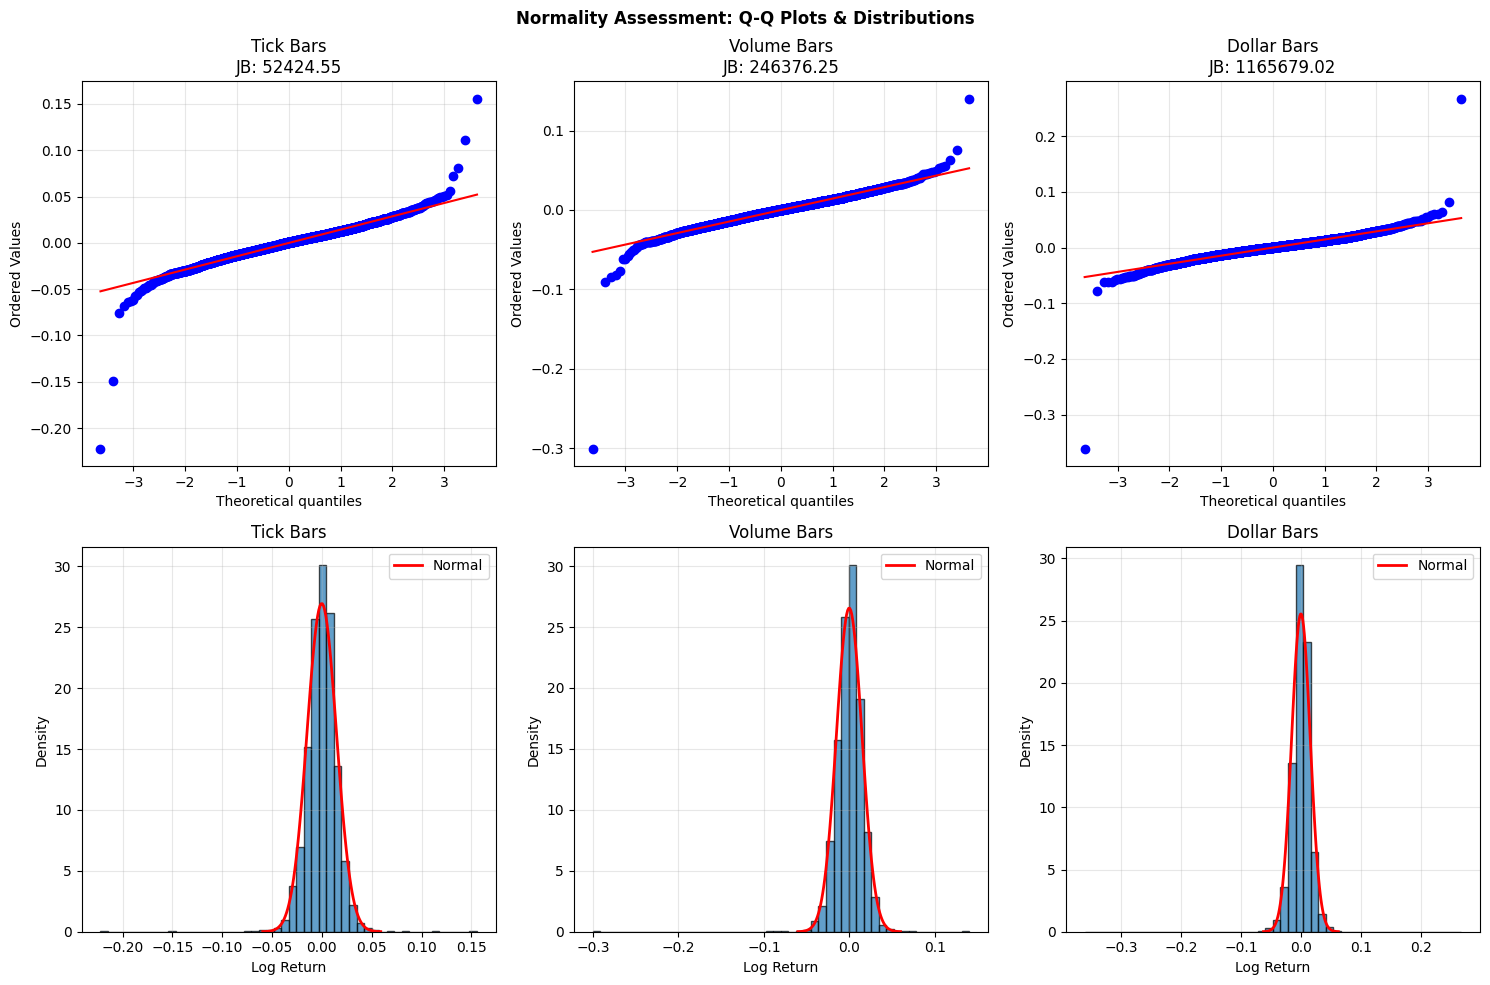

In [11]:
# Run Jarque-Bera normality test
jb_results = {
    'Tick': {
        'statistic': stats.jarque_bera(tick_returns)[0],
        'p_value': stats.jarque_bera(tick_returns)[1],
        'skewness': stats.skew(tick_returns),
        'kurtosis': stats.kurtosis(tick_returns)
    },
    'Volume': {
        'statistic': stats.jarque_bera(volume_returns)[0],
        'p_value': stats.jarque_bera(volume_returns)[1],
        'skewness': stats.skew(volume_returns),
        'kurtosis': stats.kurtosis(volume_returns)
    },
    'Dollar': {
        'statistic': stats.jarque_bera(dollar_returns)[0],
        'p_value': stats.jarque_bera(dollar_returns)[1],
        'skewness': stats.skew(dollar_returns),
        'kurtosis': stats.kurtosis(dollar_returns)
    }
}

print("="*60)
print("JARQUE-BERA NORMALITY TEST")
print("="*60)
print("Null hypothesis: Returns are normally distributed")
print("Lower statistic = more normal\n")

for name, res in sorted(jb_results.items(), key=lambda x: x[1]['statistic']):
    print(f"{name:12} bars: JB={res['statistic']:10.2f}  p={res['p_value']:.6f}  "
          f"Skew={res['skewness']:7.4f}  Kurt={res['kurtosis']:7.4f}")

print("="*60)

winner = min(jb_results.items(), key=lambda x: x[1]['statistic'])
print(f"\n✓ WINNER: {winner[0]} bars (JB={winner[1]['statistic']:.4f})")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

returns_dict = {'Tick': tick_returns, 'Volume': volume_returns, 'Dollar': dollar_returns}

# Q-Q plots (top row)
for ax, (name, ret) in zip(axes[0], returns_dict.items()):
    stats.probplot(ret, dist="norm", plot=ax)
    ax.set_title(f'{name} Bars\nJB: {jb_results[name]["statistic"]:.2f}')
    ax.grid(True, alpha=0.3)

# Histograms (bottom row)
for ax, (name, ret) in zip(axes[1], returns_dict.items()):
    ax.hist(ret, bins=50, density=True, alpha=0.7, edgecolor='black')
    mu, sigma = ret.mean(), ret.std()
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
    ax.set_title(f'{name} Bars')
    ax.set_xlabel('Log Return')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Normality Assessment: Q-Q Plots & Distributions', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary & Conclusions

In [12]:
print("="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nDataset: {len(df_all):,} ticks of POWRUSDT")
print(f"Bars formed: {len(tick_bars):,} tick / {len(volume_bars):,} volume / {len(dollar_bars):,} dollar")
print(f"\nProcessing time (Polars): {tick_time + vol_time + dollar_time:.2f}s")
print(f"Estimated Pandas time: ~6+ hours")
print(f"Speedup: ~{(6*3600)/(tick_time + vol_time + dollar_time):.0f}x faster!")

print("\n" + "="*60)
print("METRIC WINNERS")
print("="*60)

metrics = [
    ("Weekly stability (lowest σ)", min([("Tick", tick_std), ("Volume", volume_std), ("Dollar", dollar_std)], key=lambda x: x[1])),
    ("Serial correlation (lowest)", min([("Tick", abs(tick_corr)), ("Volume", abs(volume_corr)), ("Dollar", abs(dollar_corr))], key=lambda x: x[1])),
    ("Variance stability (lowest)", min([("Tick", tick_vov), ("Volume", volume_vov), ("Dollar", dollar_vov)], key=lambda x: x[1])),
    ("Normality (lowest JB)", min(jb_results.items(), key=lambda x: x[1]['statistic']))
]

for metric, winner in metrics:
    if len(winner) == 2:
        print(f"{metric:35} {winner[0]}")
    else:
        print(f"{metric:35} {winner}")

print("="*60)

FINAL RESULTS SUMMARY

Dataset: 3,425,914 ticks of POWRUSDT
Bars formed: 5,002 tick / 5,000 volume / 5,000 dollar

Processing time (Polars): 0.38s
Estimated Pandas time: ~6+ hours
Speedup: ~56736x faster!

METRIC WINNERS
Weekly stability (lowest σ)         Volume
Serial correlation (lowest)         Volume
Variance stability (lowest)         Volume
Normality (lowest JB)               Tick


## Save Processed Bars (Optional)

In [13]:
# Save as Parquet for future use (Polars native format)
output_dir = Path('../processed_bars/POWRUSDT')
output_dir.mkdir(parents=True, exist_ok=True)

tick_bars.write_parquet(output_dir / 'tick_bars_20240924_20251021.parquet')
volume_bars.write_parquet(output_dir / 'volume_bars_20240924_20251021.parquet')
dollar_bars.write_parquet(output_dir / 'dollar_bars_20240924_20251021.parquet')

print(f"✓ Bars saved to {output_dir}")
print(f"  - tick_bars_20240924_20251021.parquet ({len(tick_bars):,} rows)")
print(f"  - volume_bars_20240924_20251021.parquet ({len(volume_bars):,} rows)")
print(f"  - dollar_bars_20240924_20251021.parquet ({len(dollar_bars):,} rows)")

✓ Bars saved to ../processed_bars/POWRUSDT
  - tick_bars_polars.parquet (5,002 rows)
  - volume_bars_polars.parquet (5,000 rows)
  - dollar_bars_polars.parquet (5,000 rows)
